<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/(T%20Orth)cosian%20dist_%2025%20instance_2000%20pair_%20160%20outer%20shift_Threshold%20verification%20with%20Middle_TP-FN_TN-FP_FAR-FFR-EER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

** subjects  (train subject (ts) , new subject (ns) ):

1) Train subject i (ts[i] )
2) Train Subject i and Train Subject j (ts[i] , ts[j] )
3) Train subject and New subject  (ts , ns)
4) New subject i ( ns[i] )
5) New Subject i and New Subject j (ns[i] , ns[j] )

'''


'\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n** subjects  (train subject (ts) , new subject (ns) ):\n\n1) Train subject i (ts[i] )\n2) Train Subject i and Train Subject j (ts[i] , ts[j] )\n3) Train subject and New subject  (ts , ns)\n4) New subject i ( ns[i] )\n5) New Subject i and New Subject j (ns[i] , ns[j] )\n\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.8MB/s 


In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[10,40,61]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =160  # outer step len
sample_per_window = 160
window_len= 20
batch_size=64

#Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
#Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]


In [4]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime
import statistics

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime


# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model
from keras import backend as KerasBackend
from keras.callbacks import EarlyStopping



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [0]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


In [25]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sample_per_window - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = math.floor(len(subject_img_number_array_shuffled)* 0.75)
val_index = train_index + (train_index//5)

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
subject_img_number

59

In [27]:
a = [1,2,3,4,5,6]
b= [4,6,8]
c= list(set(a)-set(b))
c

[1, 2, 3, 5]

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        

        # Orthogonal Channel
        DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsOrt[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        DataChannelsOrt[e][2]=DataChannelsNormal[e][2]-ProjectionVector(DataChannelsOrt[e][0].copy(),DataChannelsNormal[e][2].copy())*OrthogonalFlag\
                                                      -ProjectionVector(DataChannelsOrt[e][1].copy(),DataChannelsNormal[e][2].copy())*OrthogonalFlag

        e = e+1
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, sample_per_window), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsOrt[r][i][0+j*OuterSampleShift + z*InnerSampleShift:sample_per_window+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


Epoch 1/50
1235/1235 [==============================] - 35s 28ms/step - loss: 2.9871 - acc: 0.1977 - val_loss: 1.8471 - val_acc: 0.4795
Epoch 2/50
1235/1235 [==============================] - 32s 26ms/step - loss: 1.5882 - acc: 0.5058 - val_loss: 0.8718 - val_acc: 0.7556
Epoch 3/50
1235/1235 [==============================] - 32s 26ms/step - loss: 0.8787 - acc: 0.7163 - val_loss: 0.5069 - val_acc: 0.8465
Epoch 4/50
1235/1235 [==============================] - 33s 26ms/step - loss: 0.5507 - acc: 0.8181 - val_loss: 0.4205 - val_acc: 0.8596
Epoch 5/50
1235/1235 [==============================] - 33s 26ms/step - loss: 0.3682 - acc: 0.8781 - val_loss: 0.2214 - val_acc: 0.9295
Epoch 6/50
1235/1235 [==============================] - 33s 26ms/step - loss: 0.2545 - acc: 0.9139 - val_loss: 0.1275 - val_acc: 0.9631
Epoch 7/50
1235/1235 [==============================] - 33s 26ms/step - loss: 0.1831 - acc: 0.9378 - val_loss: 0.1420 - val_acc: 0.9524
Epoch 8/50
1235/1235 [==========================

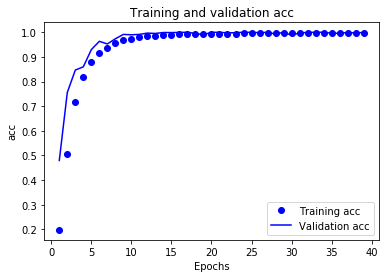

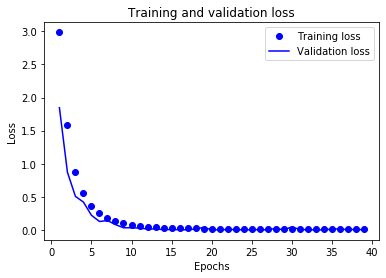

In [0]:
# Construct Data Generator

GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled=subject_number_array_shuffled,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled=train_shuff)

GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ListChannel=list_channel,
                                        RemoveBaseLineFlag=RemoveBaseLine,
                                        OrthogonalFlag=Orthogonal,
                                        WindowLen=window_len,
                                        OuterSampleShift=outer_sample_shift,
                                        InnerSampleShift=inner_sample_shift,
                                        SampelNumberPerSec=sampel_number_per_sec,
                                        ImageArrayShuffled=val_shuff)

GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ListChannel=list_channel,
                                RemoveBaseLineFlag=RemoveBaseLine,
                                OrthogonalFlag=Orthogonal,
                                WindowLen=window_len,
                                OuterSampleShift=outer_sample_shift,
                                InnerSampleShift=inner_sample_shift,
                                SampelNumberPerSec=sampel_number_per_sec,
                                ImageArrayShuffled=test_shuff)

#################################################################################################
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding='same', input_shape = (window_len,160,ch_number) ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(subject_numberT, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

#################################################################################################
earlystopping_callback = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0,patience=10,mode='auto', restore_best_weights=True)
# Train the Model
history = model.fit_generator(epochs =50,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              callbacks=[earlystopping_callback],
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

In [0]:
#model.save('/content/drive/My Drive/mymodels/orth_newmodel_Oz_T7_C3.h5')

In [10]:
model = load_model('/content/drive/My Drive/mymodels/orth_newmodel_Oz_T7_C3.h5')
model.summary()
model.pop()
model.pop()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 20, 160, 128)      3584      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 80, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 78, 256)        295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 39, 256)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 37, 512)        1180160   
____________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def subject_Predict_generator(batch_size, mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject

In [0]:
total_vector=[]
subject_img_idx_array = np.arange(subject_img_number)

for i in range(109):
  Si_vectors = subject_Predict_generator(len(subject_img_idx_array), model, [i], subject_img_idx_array)
  total_vector.append(Si_vectors)



In [16]:
import h5py
hf = h5py.File('/content/drive/My Drive/mymodels/total_vectors_orth_newmodel_Oz_T7_C3_160.h5', 'w')
hf.create_dataset('/content/drive/My Drive/mymodels/dataset_total_vectors', data=total_vector)
hf.close()
hf = h5py.File('/content/drive/My Drive/mymodels/total_vectors_orth_newmodel_Oz_T7_C3_160.h5', 'r')
vec = hf.get('/content/drive/My Drive/mymodels/dataset_total_vectors')
vec


<HDF5 dataset "dataset_total_vectors": shape (109, 59, 1024), type "<f4">

In [0]:
### verification with middle of samples

def VerifySubject(threshold, s1, smp1, s2, smp2):
  list_d =[]

  for i in range(len(smp1)):
    #print(s1 ,vec1[i] )
    d= distance.cosine(vec[s1][smp1[i]], vec[s2][smp2[i]])
    list_d.append(d)
  midd = statistics.median_low(list_d)

  if (midd) <threshold :
    return 0 # same
  else:
    return 1 # different


In [0]:
### generate data for verification
def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  
  threshold = 0
  pair_number = 2000
  sample_img_num = 25
  Batch_size = 25
  ITER = pair_number //2


  path = "/content/drive/My Drive/z_Middle Verification Threshold_EER/"+" h5 file- cosian dist task1_ORTH new model" +str(sample_img_num)+"sample num_"+str(pair_number)+"pair_"+ "ouer shift" + str(outer_sample_shift)

  try:
      os.mkdir(path)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s " % path)



  
  ## CSV file name 
  csvFileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".csv"
  completeName = os.path.join(path, csvFileName )

  png_FileName =str(sample_img_num)+"sample num_"+str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".png"
  png_completeName = os.path.join(path, png_FileName )

  list_threshold = []
  list_TP = []
  list_TN = []
  list_FP = []
  list_FN = []
  list_FRR = []
  list_FAR = []
  list_EER = []
  list_Correct_Verifi_Percentage = []
  list_threshold_result =[]


  for j in range(1,30):

      threshold =0.25+ (j*0.002)
      #threshold = j
      TP =0
      TN =0
      FP =0
      FN =0
      FAR =0
      FRR =0
      EER =0
      true_result= 0
      false_result = 0
      Correct_Verifi_Percentage = 0

      for i in range(ITER):
        
          # subject 1 Genuine
          S1_rand = random.randint(start_index_s1, end_index_s1)
          # shuffled img indx array
          pre_S1_img_shuffled = np.arange(subject_img_number)
          np.random.shuffle(pre_S1_img_shuffled)

          # group sample 1
          S1_Sample_rand1 = pre_S1_img_shuffled[:sample_img_num]
          # group sample 2
          S1_Sample_rand2 = pre_S1_img_shuffled[sample_img_num : sample_img_num *2]

          # Genuine verify
          result1 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
          
          if result1 == 0:
            true_result = true_result+1
            TP = TP +1 #TP
          else:
            false_result = false_result+1
            FN = FN +1

          # subject 2
          S2_rand = random.randint(start_index_s2, end_index_s2)
          while S2_rand == S1_rand:
            S2_rand = random.randint(start_index_s2, end_index_s2)

          # shuffled img indx array
          pre_S2_img_shuffled=np.arange(subject_img_number)
          np.random.shuffle(pre_S2_img_shuffled)
          # group sample
          S2_Sample_rand = pre_S2_img_shuffled[:sample_img_num]

          # Impostor vrify
          result2 = VerifySubject( threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

          if result2 == 1:
            true_result = true_result+1
            TN = TN +1
          else: 
            false_result = false_result+1
            FP = FP +1
        
      #print(result1 , result2)
      Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
      FAR = FP / (FP+TN)
      FRR = FN / (FN+TP)
      EER = (FAR+FRR) / 2

      list_threshold.append(threshold)
      list_TP.append(TP)
      list_TN.append(TN)
      list_FP.append(FP)
      list_FN.append(FN)
      list_FAR.append(FAR)
      list_FRR.append(FRR)
      list_EER.append(EER)
      list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
      ## print result
      print(threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )

  ##plot
  plt.plot(list_FRR, list_FAR  ) 
  plt.xlabel('FRR') 
  plt.ylabel('FAR') 
  plt.legend()
  plt.savefig(png_completeName) 


  list_threshold_result.append([(list_threshold[j], list_Correct_Verifi_Percentage[j], list_FAR[j], list_FRR[j] , list_EER[j], list_TP[j], list_FN[j], list_TN[j], list_FP[j] ) for j in range(len(list_Correct_Verifi_Percentage)) ])

  with open(completeName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(list_threshold_result[0])


Successfully created the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/ h5 file- cosian dist task1_ORTH new model25sample num_2000pair_ouer shift160 
0.254 . 
 96.1 % 
 true_result: 1922 false_result: 78 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.039 

0.258 . 
 97.1 % 
 true_result: 1942 false_result: 58 
 TP: 958 FN: 42 FRR: 0.042 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.029 

0.262 . 
 96.6 % 
 true_result: 1932 false_result: 68 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.034 

0.266 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 957 FN: 43 FRR: 0.043 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.03 

0.27 . 
 96.9 % 
 true_result: 1938 false_result: 62 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.031 

0.274 . 
 97.05 % 
 true_result: 1941 false_result: 59 
 TP: 964 FN: 36 FRR: 0.036 
 TN: 977 FP: 23 FAR: 0.023 
 EER: 0.0295 

0.278 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 975 FN: 25 FRR:

No handles with labels found to put in legend.


0.306 . 
 97.65 % 
 true_result: 1953 false_result: 47 
 TP: 993 FN: 7 FRR: 0.007 
 TN: 960 FP: 40 FAR: 0.04 
 EER: 0.0235 



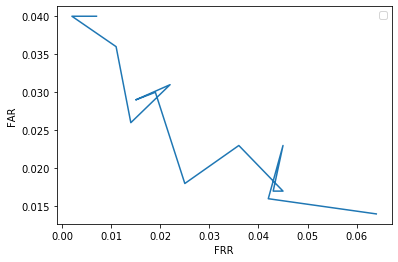

In [19]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89) 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/ h5 file- cosian dist task1_ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.7 % 
 true_result: 1914 false_result: 86 
 TP: 929 FN: 71 FRR: 0.071 
 TN: 985 FP: 15 FAR: 0.015 
 EER: 0.043 

0.254 . 
 95.95 % 
 true_result: 1919 false_result: 81 
 TP: 935 FN: 65 FRR: 0.065 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.0405 

0.256 . 
 96.65 % 
 true_result: 1933 false_result: 67 
 TP: 944 FN: 56 FRR: 0.056 
 TN: 989 FP: 11 FAR: 0.011 
 EER: 0.0335 

0.258 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 952 FN: 48 FRR: 0.048 
 TN: 988 FP: 12 FAR: 0.012 
 EER: 0.03 

0.26 . 
 96.4 % 
 true_result: 1928 false_result: 72 
 TP: 946 FN: 54 FRR: 0.054 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.036 

0.262 . 
 96.5 % 
 true_result: 1930 false_result: 70 
 TP: 955 FN: 45 FRR: 0.045 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.035 

0.264 . 
 97.5 % 
 true_result: 1950 false_result: 50 
 TP: 961 FN: 39 FRR: 0

No handles with labels found to put in legend.


0.308 . 
 97.4 % 
 true_result: 1948 false_result: 52 
 TP: 991 FN: 9 FRR: 0.009 
 TN: 957 FP: 43 FAR: 0.043 
 EER: 0.026 



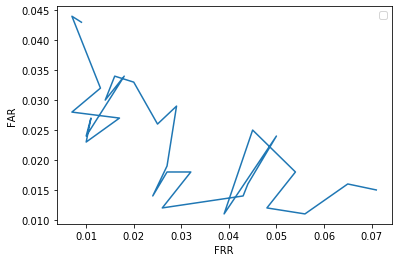

In [21]:
#1. train subject , train subject
counter_true_false_result(0,89, 0,89) 

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/ h5 file- cosian dist task1_Orth new model25sample num_2000pair_ouer shift8 failed
0.255 . 
 96.0 % 
 true_result: 1920 false_result: 80 
 TP: 941 FN: 59 FRR: 0.059 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.04 

0.26 . 
 96.6 % 
 true_result: 1932 false_result: 68 
 TP: 952 FN: 48 FRR: 0.048 
 TN: 980 FP: 20 FAR: 0.02 
 EER: 0.034 

0.265 . 
 96.7 % 
 true_result: 1934 false_result: 66 
 TP: 959 FN: 41 FRR: 0.041 
 TN: 975 FP: 25 FAR: 0.025 
 EER: 0.033 

0.27 . 
 97.0 % 
 true_result: 1940 false_result: 60 
 TP: 959 FN: 41 FRR: 0.041 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.03 

0.275 . 
 96.85 % 
 true_result: 1937 false_result: 63 
 TP: 966 FN: 34 FRR: 0.034 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.0315 

0.28 . 
 96.95 % 
 true_result: 1939 false_result: 61 
 TP: 968 FN: 32 FRR: 0.032 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.0305 

0.28500000000000003 . 
 97.85 % 
 true_result: 1957 false_result: 43 
 TP: 988 FN: 

No handles with labels found to put in legend.


0.32 . 
 97.65 % 
 true_result: 1953 false_result: 47 
 TP: 995 FN: 5 FRR: 0.005 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.0235 



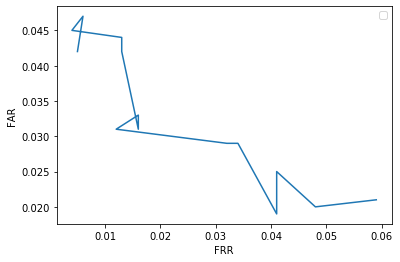

In [0]:
#2. train subject , new subject
counter_true_false_result(0,89, 90,107)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/ h5 file- cosian dist task1_ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 93.0 % 
 true_result: 1860 false_result: 140 
 TP: 869 FN: 131 FRR: 0.131 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.07 

0.254 . 
 92.7 % 
 true_result: 1854 false_result: 146 
 TP: 870 FN: 130 FRR: 0.13 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.07300000000000001 

0.256 . 
 93.45 % 
 true_result: 1869 false_result: 131 
 TP: 887 FN: 113 FRR: 0.113 
 TN: 982 FP: 18 FAR: 0.018 
 EER: 0.0655 

0.258 . 
 93.15 % 
 true_result: 1863 false_result: 137 
 TP: 880 FN: 120 FRR: 0.12 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0685 

0.26 . 
 93.15 % 
 true_result: 1863 false_result: 137 
 TP: 887 FN: 113 FRR: 0.113 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.0685 

0.262 . 
 94.15 % 
 true_result: 1883 false_result: 117 
 TP: 902 FN: 98 FRR: 0.098 
 TN: 981 FP: 19 FAR: 0.019 
 EER: 0.0585 

0.264 . 
 94.6 % 
 true_result: 1892 false_result: 

No handles with labels found to put in legend.


0.308 . 
 98.0 % 
 true_result: 1960 false_result: 40 
 TP: 989 FN: 11 FRR: 0.011 
 TN: 971 FP: 29 FAR: 0.029 
 EER: 0.02 



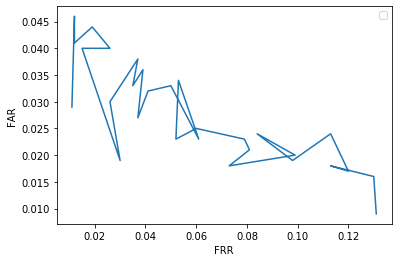

In [22]:
#3. new subject , new subject

counter_true_false_result(90,107, 0,89)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/ h5 file- cosian dist task1_ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 93.15 % 
 true_result: 1863 false_result: 137 
 TP: 865 FN: 135 FRR: 0.135 
 TN: 998 FP: 2 FAR: 0.002 
 EER: 0.0685 

0.254 . 
 94.0 % 
 true_result: 1880 false_result: 120 
 TP: 882 FN: 118 FRR: 0.118 
 TN: 998 FP: 2 FAR: 0.002 
 EER: 0.06 

0.256 . 
 93.65 % 
 true_result: 1873 false_result: 127 
 TP: 876 FN: 124 FRR: 0.124 
 TN: 997 FP: 3 FAR: 0.003 
 EER: 0.0635 

0.258 . 
 94.85 % 
 true_result: 1897 false_result: 103 
 TP: 898 FN: 102 FRR: 0.102 
 TN: 999 FP: 1 FAR: 0.001 
 EER: 0.0515 

0.26 . 
 95.25 % 
 true_result: 1905 false_result: 95 
 TP: 907 FN: 93 FRR: 0.093 
 TN: 998 FP: 2 FAR: 0.002 
 EER: 0.0475 

0.262 . 
 95.35 % 
 true_result: 1907 false_result: 93 
 TP: 910 FN: 90 FRR: 0.09 
 TN: 997 FP: 3 FAR: 0.003 
 EER: 0.0465 

0.264 . 
 94.4 % 
 true_result: 1888 false_result: 112 
 TP: 891 FN: 1

No handles with labels found to put in legend.


0.308 . 
 97.9 % 
 true_result: 1958 false_result: 42 
 TP: 989 FN: 11 FRR: 0.011 
 TN: 969 FP: 31 FAR: 0.031 
 EER: 0.020999999999999998 



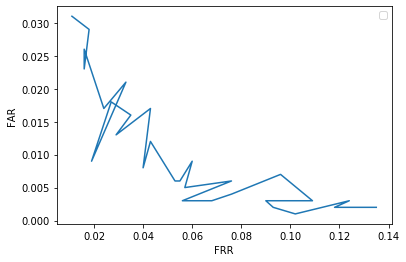

In [23]:
#4. new subject , new subject

counter_true_false_result(90,107, 90,107)

Creation of the directory /content/drive/My Drive/z_Middle Verification Threshold_EER/ h5 file- cosian dist task1_ORTH new model25sample num_2000pair_ouer shift160 failed
0.252 . 
 95.4 % 
 true_result: 1908 false_result: 92 
 TP: 925 FN: 75 FRR: 0.075 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.046 

0.254 . 
 96.15 % 
 true_result: 1923 false_result: 77 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 986 FP: 14 FAR: 0.014 
 EER: 0.0385 

0.256 . 
 95.3 % 
 true_result: 1906 false_result: 94 
 TP: 922 FN: 78 FRR: 0.078 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.047 

0.258 . 
 95.85 % 
 true_result: 1917 false_result: 83 
 TP: 934 FN: 66 FRR: 0.066 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0415 

0.26 . 
 96.55 % 
 true_result: 1931 false_result: 69 
 TP: 948 FN: 52 FRR: 0.052 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.0345 

0.262 . 
 95.1 % 
 true_result: 1902 false_result: 98 
 TP: 923 FN: 77 FRR: 0.077 
 TN: 979 FP: 21 FAR: 0.021 
 EER: 0.049 

0.264 . 
 96.45 % 
 true_result: 1929 false_result: 71 
 TP: 950 FN: 50 FR

No handles with labels found to put in legend.


0.308 . 
 97.65 % 
 true_result: 1953 false_result: 47 
 TP: 987 FN: 13 FRR: 0.013 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.0235 



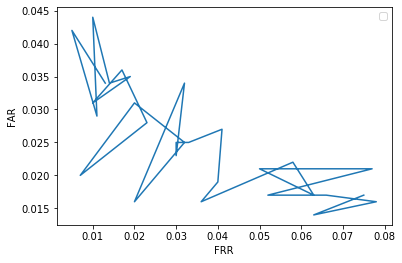

In [24]:
#5. all subject , all subject

counter_true_false_result(0,107, 0,107)